<a href="https://colab.research.google.com/github/DhruvAjayToshniwal/Bollinger-Bands-Trading-Strategy-with-Python/blob/main/Bollinger_Bands_Trading_Strategy_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas yfinance matplotlib

In [10]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define the ticker symbol
tickerSymbol = 'GOOGL'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2020-1-1', end='2023-12-31')

# See the data
print(tickerDf)

                                 Open        High         Low       Close  \
Date                                                                        
2020-01-02 00:00:00-05:00   67.420502   68.433998   67.324501   68.433998   
2020-01-03 00:00:00-05:00   67.400002   68.687500   67.365997   68.075996   
2020-01-06 00:00:00-05:00   67.581497   69.916000   67.550003   69.890503   
2020-01-07 00:00:00-05:00   70.023003   70.175003   69.578003   69.755501   
2020-01-08 00:00:00-05:00   69.740997   70.592499   69.631500   70.251999   
...                               ...         ...         ...         ...   
2023-07-10 00:00:00-04:00  118.300003  118.309998  116.139999  116.449997   
2023-07-11 00:00:00-04:00  116.290001  117.709999  115.349998  117.139999   
2023-07-12 00:00:00-04:00  118.800003  120.330002  118.410004  118.930000   
2023-07-13 00:00:00-04:00  120.930000  124.830002  120.449997  124.540001   
2023-07-14 00:00:00-04:00  124.800003  126.779999  123.489998  125.419998   

In [11]:
# Bollinger Bands
tickerDf['20 Day MA'] = tickerDf['Close'].rolling(window=20).mean()
tickerDf['20 Day STD'] = tickerDf['Close'].rolling(window=20).std()
tickerDf['Upper Band'] = tickerDf['20 Day MA'] + (tickerDf['20 Day STD'] * 2)
tickerDf['Lower Band'] = tickerDf['20 Day MA'] - (tickerDf['20 Day STD'] * 2)

# Simple Moving Averages
tickerDf['SMA_10'] = tickerDf['Close'].rolling(window=10).mean()
tickerDf['SMA_50'] = tickerDf['Close'].rolling(window=50).mean()
tickerDf['SMA_200'] = tickerDf['Close'].rolling(window=200).mean()

# Exponential Moving Averages
tickerDf['EMA_12'] = tickerDf['Close'].ewm(span=12, adjust=False).mean()
tickerDf['EMA_26'] = tickerDf['Close'].ewm(span=26, adjust=False).mean()

# Moving Average Convergence Divergence
tickerDf['MACD_line'] = tickerDf['EMA_12'] - tickerDf['EMA_26']
tickerDf['Signal_line'] = tickerDf['MACD_line'].ewm(span=9, adjust=False).mean()
tickerDf['MACD_Hist'] = tickerDf['MACD_line'] - tickerDf['Signal_line']

In [12]:
# Relative Strength Index
delta = tickerDf['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
tickerDf['RSI'] = 100 - (100/(1 + rs))

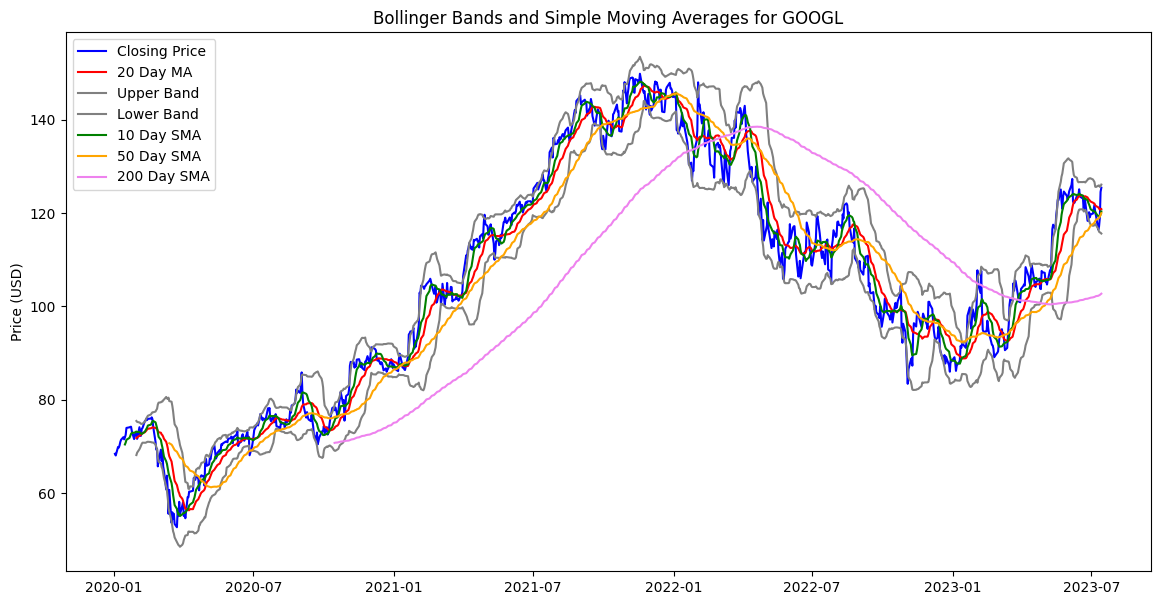

In [13]:
# Plotting Bollinger Bands, Simple Moving Averages and Closing Prices
plt.figure(figsize=(14, 7))
plt.plot(tickerDf['Close'], label='Closing Price', color='blue')
plt.plot(tickerDf['20 Day MA'], label='20 Day MA', color='red')
plt.plot(tickerDf['Upper Band'], label='Upper Band', color='grey')
plt.plot(tickerDf['Lower Band'], label='Lower Band', color='grey')
plt.plot(tickerDf['SMA_10'], label='10 Day SMA', color='green')
plt.plot(tickerDf['SMA_50'], label='50 Day SMA', color='orange')
plt.plot(tickerDf['SMA_200'], label='200 Day SMA', color='violet')
plt.title('Bollinger Bands and Simple Moving Averages for ' + tickerSymbol)
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


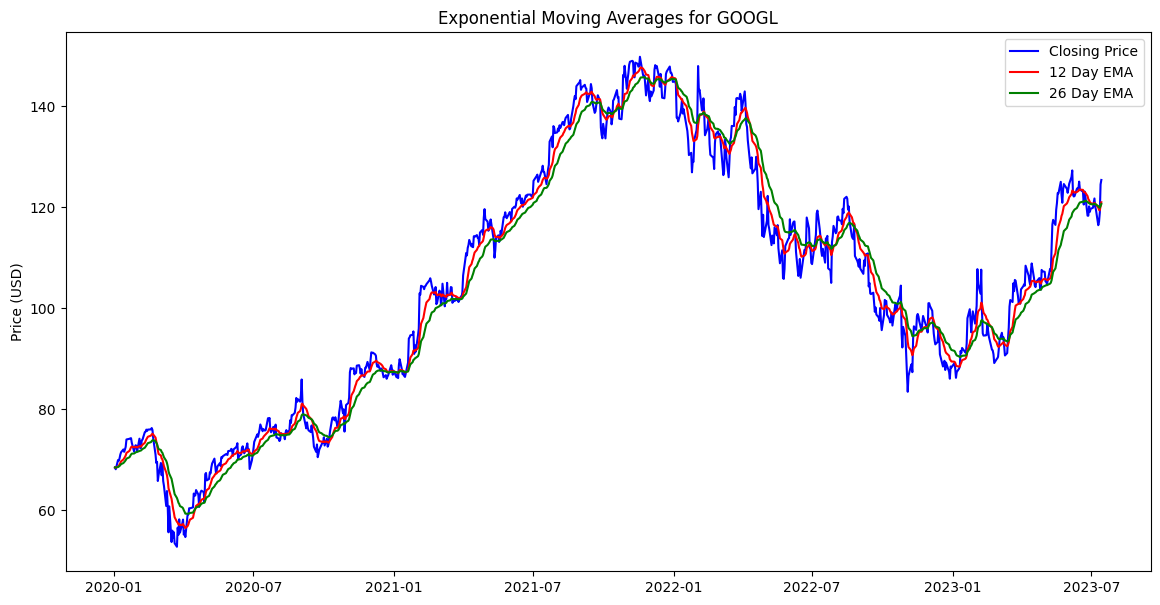

In [14]:
# Plotting Exponential Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(tickerDf['Close'], label='Closing Price', color='blue')
plt.plot(tickerDf['EMA_12'], label='12 Day EMA', color='red')
plt.plot(tickerDf['EMA_26'], label='26 Day EMA', color='green')
plt.title('Exponential Moving Averages for ' + tickerSymbol)
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


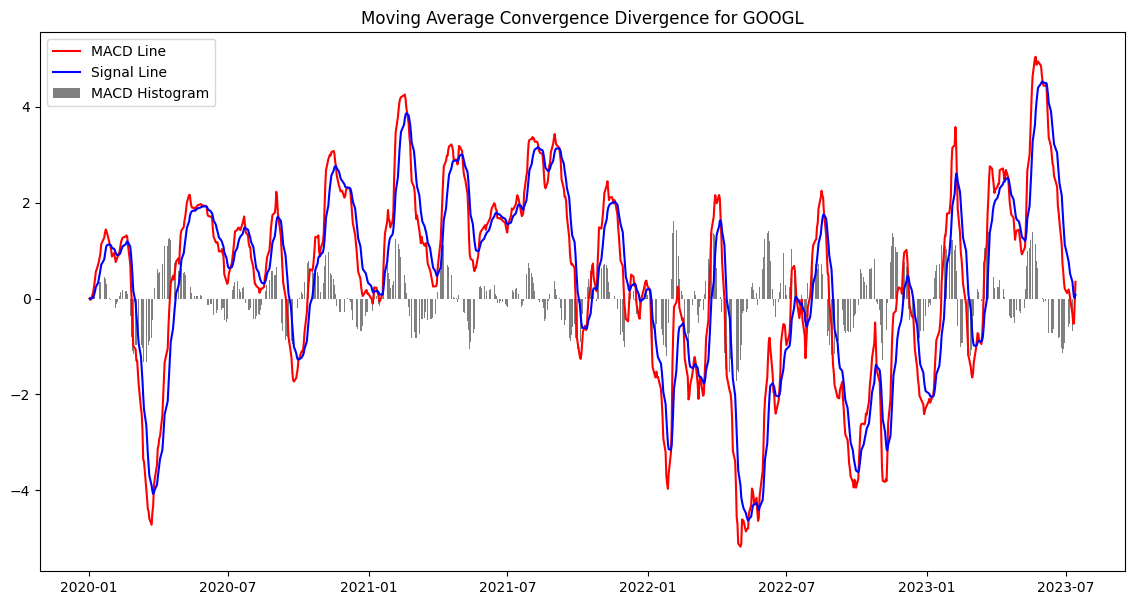

In [15]:
# Plotting Moving Average Convergence Divergence
plt.figure(figsize=(14, 7))
plt.plot(tickerDf['MACD_line'], label='MACD Line', color='red')
plt.plot(tickerDf['Signal_line'], label='Signal Line', color='blue')
plt.bar(tickerDf.index, tickerDf['MACD_Hist'], label='MACD Histogram', color='grey')
plt.title('Moving Average Convergence Divergence for ' + tickerSymbol)
plt.legend()
plt.show()

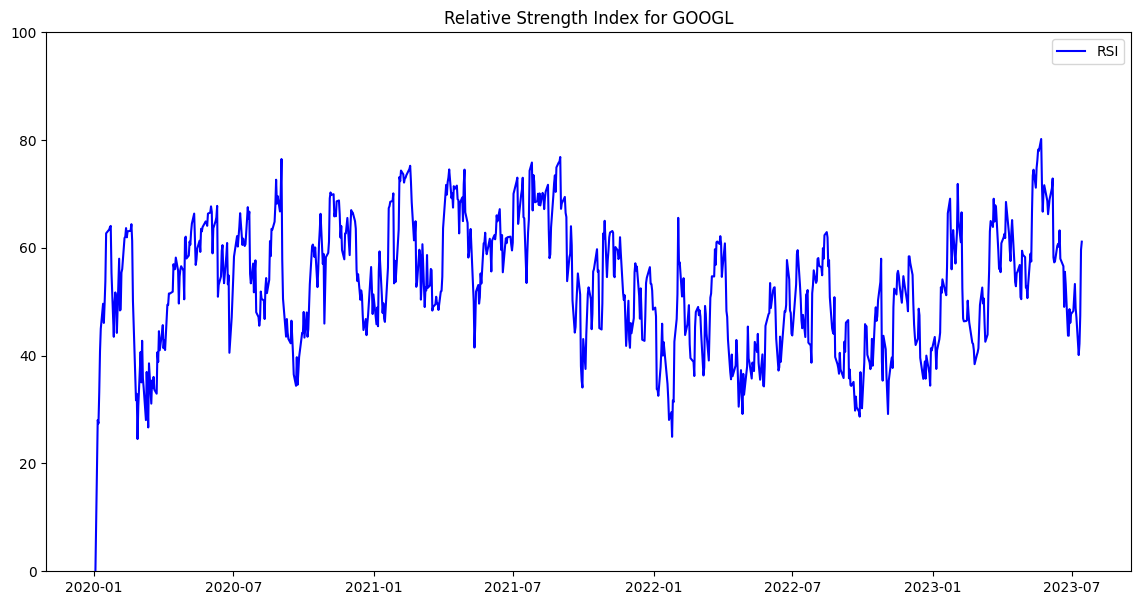

In [16]:
# Plotting Relative Strength Index
plt.figure(figsize=(14, 7))
plt.plot(tickerDf['RSI'], label='RSI', color='blue')
plt.title('Relative Strength Index for ' + tickerSymbol)
plt.ylim(0,100)
plt.legend()
plt.show()


In [20]:
initial_capital = 10000  # Define your initial capital

# Create a dataframe to hold the trading strategy actions
trades = pd.DataFrame(index=tickerDf.index)
trades['Close'] = tickerDf['Close']
trades['Lower Band'] = tickerDf['Lower Band']
trades['Upper Band'] = tickerDf['Upper Band']
trades['Buy_Signal'] = (trades['Close'] < trades['Lower Band']).astype(int)
trades['Sell_Signal'] = (trades['Close'] > trades['Upper Band']).astype(int)

# Create a dataframe for positions and holdings
positions = pd.DataFrame(index=trades.index).fillna(0)
holdings = pd.DataFrame(index=trades.index).fillna(0.0)

# Buy a 100 shares when the buy signal is triggered
positions['Holdings'] = 100*trades['Buy_Signal']

# Sell all shares when the sell signal is triggered
positions['Holdings'] = positions['Holdings'] - 100*trades['Sell_Signal']

# Can't sell if we don't have any
positions['Holdings'] = positions['Holdings'].clip(lower=0)

# Initialize the portfolio with value owned
holdings['Holdings'] = positions.multiply(trades['Close'], axis=0)

# Store the difference in shares owned
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio = holdings

# Add `cash` to portfolio
portfolio['Cash'] = initial_capital - (pos_diff.multiply(trades['Close'], axis=0)).cumsum()

# Add `total` to portfolio
portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

# Add `returns` to portfolio
portfolio['Returns'] = portfolio['Total'].pct_change()

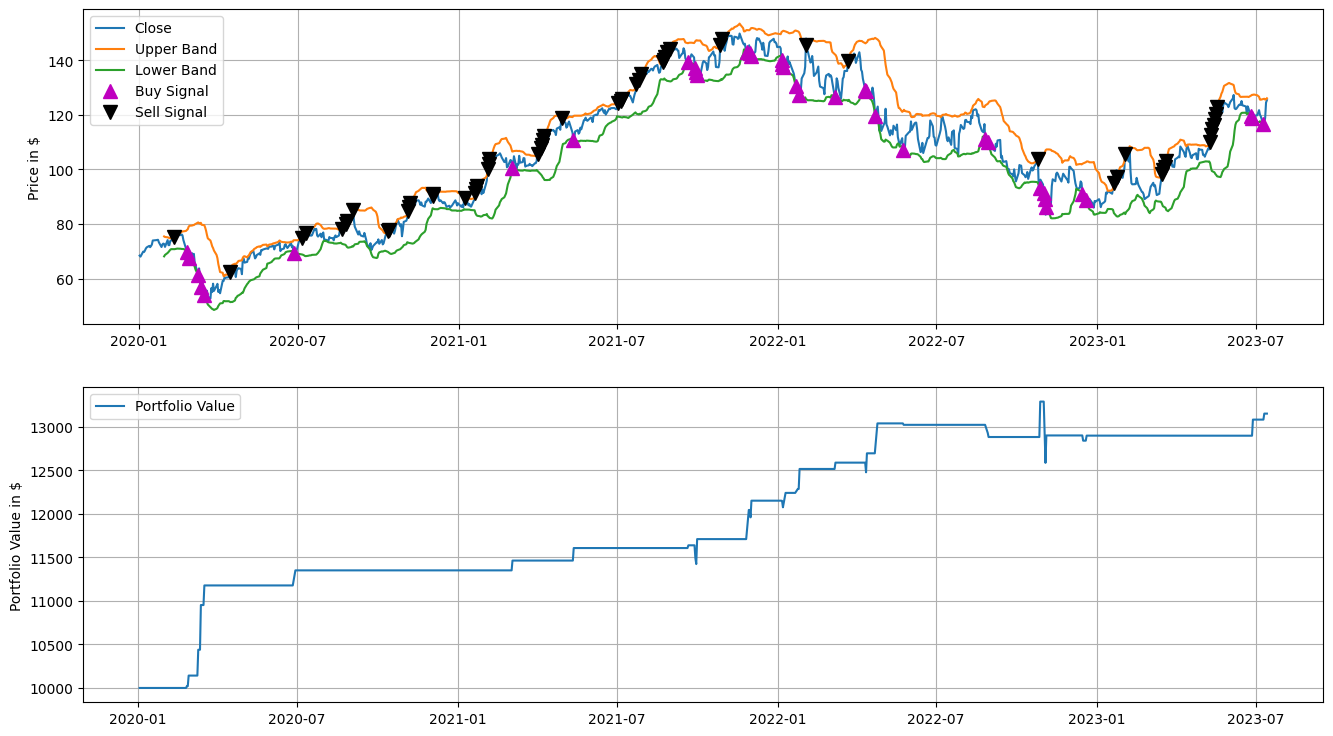

In [22]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))

for c in ['Close', 'Upper Band', 'Lower Band']:
    ax1.plot(trades.index, trades[c], label=c)
ax1.plot(trades.loc[trades['Buy_Signal'] == 1].index, trades.loc[trades['Buy_Signal'] == 1]['Lower Band'], '^', markersize=10, color='m', label='Buy Signal')
ax1.plot(trades.loc[trades['Sell_Signal'] == 1].index, trades.loc[trades['Sell_Signal'] == 1]['Upper Band'], 'v', markersize=10, color='k', label='Sell Signal')
ax1.set_ylabel('Price in $')
ax1.legend(loc='best')
ax1.grid()

ax2.plot(portfolio.index, portfolio['Total'], label='Portfolio Value')
ax2.set_ylabel('Portfolio Value in $')
ax2.legend(loc='best')
ax2.grid()

plt.show()

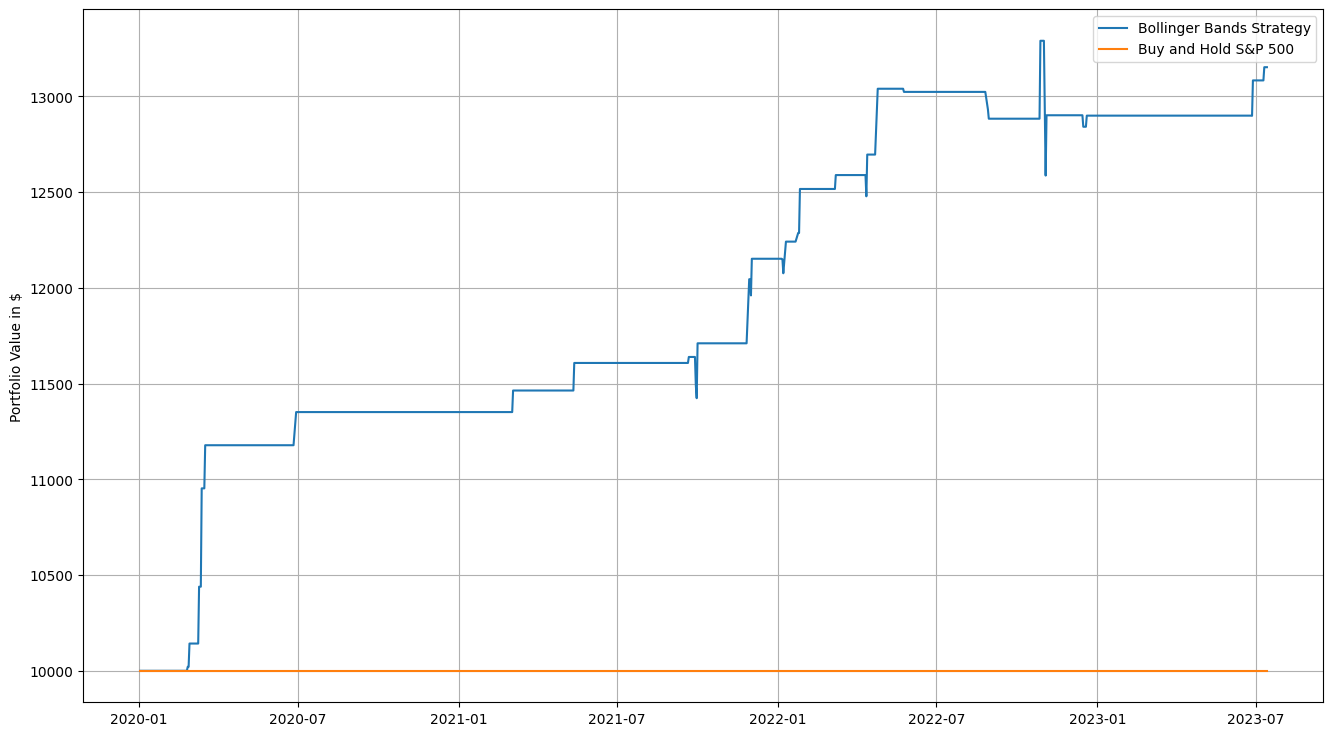

In [29]:
# Download S&P 500 data
sp_data = yf.Ticker('^GSPC').history(start='2020-1-1', end='2023-12-31')

# Create a new dataframe to hold the 'Buy and Hold' strategy
bh_portfolio = pd.DataFrame(index=sp_data.index)
bh_portfolio['Close'] = sp_data['Close']

# Buy at the start and hold
bh_portfolio['Holdings'] = initial_capital/bh_portfolio.iloc[0]['Close']*bh_portfolio['Close']
bh_portfolio['Cash'] = initial_capital - bh_portfolio['Holdings']
bh_portfolio['Total'] = bh_portfolio['Cash'] + bh_portfolio['Holdings']
bh_portfolio['Returns'] = bh_portfolio['Total'].pct_change()

# Plot both the Bollinger Bands strategy and 'Buy and Hold' strategy
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(portfolio.index, portfolio['Total'], label='Bollinger Bands Strategy')
ax.plot(bh_portfolio.index, bh_portfolio['Total'], label='Buy and Hold S&P 500')
ax.set_ylabel('Portfolio Value in $')
ax.legend(loc='best')
ax.grid()

plt.show()
